In [ ]:
 
 
 
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import timm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

 
DATA_ROOT = Path(r'C:\Users\sudha\Downloads\ISIC')

 
MODELS_DIR = Path(r'C:\Users\sudha\Downloads\ISIC\skin_cancer_project\trained_models')

VAL_IMG_PATH = DATA_ROOT / "ISIC2018_Task3_Validation_Input"
VAL_CSV_PATH = DATA_ROOT / "ISIC2018_Task3_Validation_GroundTruth" / "ISIC2018_Task3_Validation_GroundTruth.csv"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
print(f"Looking for data in: {DATA_ROOT}")
print(f"Looking for models in: {MODELS_DIR}")


MODEL_NAMES = [
    "tf_efficientnetv2_s",
    "convnext_tiny",
    "swin_tiny_patch4_window7_224"
]
CLASS_NAMES = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
NUM_CLASSES = len(CLASS_NAMES)

Using device: cpu
Looking for data in: C:\Users\sudha\Downloads\ISIC
Looking for models in: C:\Users\sudha\Downloads\ISIC\skin_cancer_project\trained_models


In [ ]:

class SkinCancerModel(nn.Module):
    def __init__(self, model_name, num_classes=NUM_CLASSES):
        super().__init__()
        self.model_name = model_name
        # Set pretrained=False because we are loading our own trained weights
        self.backbone = timm.create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        
        # Add the Dropout layer back in to match the trained model's architecture
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(feature_dim),
            nn.Dropout(0.5), 
            nn.Linear(feature_dim, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

class ISICEvalDataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.data_df = pd.read_csv(csv_path)
        self.data_df['label_str'] = self.data_df.iloc[:, 1:].idxmax(axis=1)
        class_map = {name: i for i, name in enumerate(CLASS_NAMES)}
        self.labels = self.data_df['label_str'].map(class_map).values

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_name = self.data_df.iloc[idx]['image']
        img_path = self.img_dir / f"{img_name}.jpg"
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [ ]:

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_dataset = ISICEvalDataset(VAL_IMG_PATH, VAL_CSV_PATH, val_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0) 

true_labels = val_dataset.labels

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for images, _ in tqdm(loader, desc=f"Evaluating {model.model_name}"):
            images = images.to(DEVICE)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
    return np.array(all_preds), np.array(all_probs)

In [ ]:

all_model_probs = {}
individual_accuracies = {}

for model_name in MODEL_NAMES:
    model_path = MODELS_DIR / f"{model_name}_best.pth"
    if not model_path.exists():
        print(f"⚠️ WARNING: Model file not found at {model_path}. Skipping.")
        continue

    model = SkinCancerModel(model_name).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE)['model_state_dict'])
    
    preds, probs = get_predictions(model, val_loader)
    all_model_probs[model_name] = probs
    individual_accuracies[model_name] = accuracy_score(true_labels, preds)
    print(f"✅ {model_name} Accuracy: {individual_accuracies[model_name]:.4f}")

Evaluating tf_efficientnetv2_s: 100%|██████████| 7/7 [00:14<00:00,  2.05s/it]


✅ tf_efficientnetv2_s Accuracy: 0.8860


Evaluating convnext_tiny: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]


✅ convnext_tiny Accuracy: 0.8187


Evaluating swin_tiny_patch4_window7_224: 100%|██████████| 7/7 [00:14<00:00,  2.12s/it]

✅ swin_tiny_patch4_window7_224 Accuracy: 0.8290


C:\Users\sudha\AppData\Local\Temp\ipykernel_38648\1306975633.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='magma')



🚀 FINAL ENSEMBLE ACCURACY (Soft Voting): 0.8808


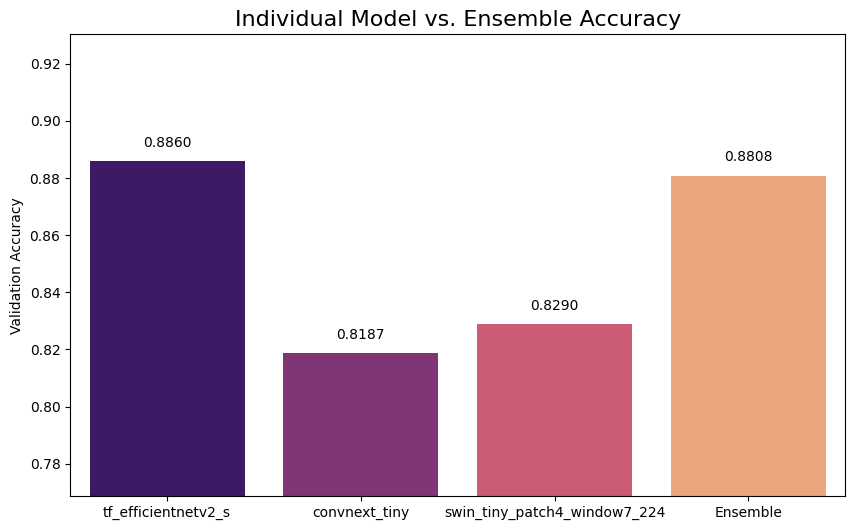


📊 ENSEMBLE CLASSIFICATION REPORT
              precision    recall  f1-score   support

         MEL       0.79      0.71      0.75        21
          NV       0.95      0.93      0.94       123
         BCC       0.72      0.87      0.79        15
       AKIEC       0.62      0.62      0.62         8
         BKL       0.78      0.82      0.80        22
          DF       1.00      1.00      1.00         1
        VASC       1.00      1.00      1.00         3

    accuracy                           0.88       193
   macro avg       0.84      0.85      0.84       193
weighted avg       0.88      0.88      0.88       193



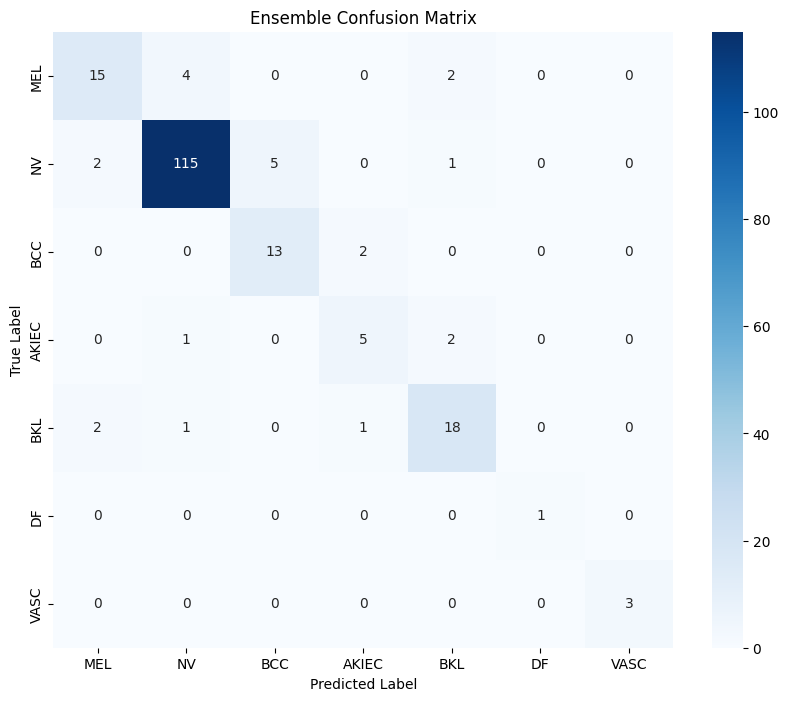

In [ ]:

if all_model_probs:
    avg_probs = np.mean(list(all_model_probs.values()), axis=0)
    ensemble_preds = np.argmax(avg_probs, axis=1)
    ensemble_accuracy = accuracy_score(true_labels, ensemble_preds)

    print("\n" + "="*50)
    print(f"🚀 FINAL ENSEMBLE ACCURACY (Soft Voting): {ensemble_accuracy:.4f}")
    print("="*50)

    plt.figure(figsize=(10, 6))
    accuracies = {**individual_accuracies, 'Ensemble': ensemble_accuracy}
    sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='magma')
    plt.title('Individual Model vs. Ensemble Accuracy', fontsize=16)
    plt.ylabel('Validation Accuracy')
    plt.ylim(bottom=max(0, min(accuracies.values()) - 0.05))
    for index, value in enumerate(accuracies.values()):
        plt.text(index, value + 0.005, f"{value:.4f}", ha='center')
    plt.show()

    print("\n📊 ENSEMBLE CLASSIFICATION REPORT")
    print(classification_report(true_labels, ensemble_preds, target_names=CLASS_NAMES))

    cm = confusion_matrix(true_labels, ensemble_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Ensemble Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("\n❌ No models were found to evaluate. Please check that training is complete.")


In [ ]:
 
import os, sys, numpy as np, pandas as pd, torch, torch.nn.functional as F
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


val_input_dir = Path(r"C:\Users\sudha\Downloads\ISIC\ISIC2018_Task3_Validation_Input")
gt_dir = Path(r"C:\Users\sudha\Downloads\ISIC\ISIC2018_Task3_Validation_GroundTruth")
# -------------------------------------------------------

print("Checking paths...")
print("val_input_dir exists?:", val_input_dir.exists(), val_input_dir)
print("gt_dir exists?:", gt_dir.exists(), gt_dir)

if not gt_dir.exists():
    print("\nGround-truth directory not found. List parent dir contents for debugging:")
    print(list(Path(r"C:\Users\sudha\Downloads\ISIC").iterdir()))
    raise RuntimeError("Ground-truth directory not found. Fix gt_dir path and re-run this cell.")

# find gt file
gt_file = None
for ext in ('.csv','.xlsx','.xls','.json','.txt'):
    candidate = next(gt_dir.glob(f'*{ext}'), None)
    if candidate:
        gt_file = candidate
        break

print("Found GT file:", gt_file)
if gt_file is None:
    print("Ground-truth dir contents:", list(gt_dir.iterdir()))
    raise RuntimeError("No GT csv/xlsx/json found in gt_dir. Please confirm gt_dir or place the ground-truth file there.")

# --- read GT table 
def read_gt_table(p):
    p = Path(p)
    if p.suffix.lower() in ('.csv', '.txt'):
        try:
            return pd.read_csv(p)
        except Exception:
            return pd.read_table(p)
    elif p.suffix.lower() in ('.xlsx', '.xls'):
        return pd.read_excel(p)
    elif p.suffix.lower() == '.json':
        return pd.read_json(p)
    else:
        raise RuntimeError("Unsupported ground-truth format: " + p.suffix)

df = read_gt_table(gt_file)
print("\nGT columns:", list(df.columns))
print(df.head().to_string(index=False))

cols = [c.strip().lower() for c in df.columns]
col_map = dict(zip(cols, df.columns))
img_col_candidates = ['image','image_id','image_name','imageid','name','filename','imagefile']
img_col = next((col_map[c] for c in img_col_candidates if c in col_map), None)
if img_col is None:
    img_col = df.columns[0]
    print("Using first column as image id:", img_col)

CLASS_NAMES = globals().get('CLASS_NAMES', None)
class_prob_cols = []
if CLASS_NAMES is not None:
    for cname in CLASS_NAMES:
        # match ignoring case
        matched = next((orig for orig in df.columns if orig.lower()==cname.lower()), None)
        if matched:
            class_prob_cols.append(matched)

if not class_prob_cols:
    cand = [c for c in df.columns if c != img_col and pd.api.types.is_numeric_dtype(df[c])]
    if 2 <= len(cand) <= 20:
        class_prob_cols = cand

label_col = None
if not class_prob_cols:
    for c in df.columns:
        if c == img_col: continue
        if df[c].nunique() < 50:
            label_col = c
            break

print("Detected img_col:", img_col)
print("Detected class_prob_cols:", class_prob_cols)
print("Detected label_col:", label_col)

img2idx = {}
if class_prob_cols:
    order = class_prob_cols
    for _, row in df.iterrows():
        img = str(row[img_col]).strip()
        probs = np.array([row[c] for c in order], dtype=float)
        if np.isnan(probs).any():
            continue
        img2idx[img] = int(np.argmax(probs))
    if CLASS_NAMES is None:
        CLASS_NAMES = order
else:
    if label_col is None:
        raise RuntimeError("Could not detect class columns or label column in GT file. Inspect GT file format.")
    labels = df[label_col].astype(str).tolist()
    unique_labels = sorted(list(set(labels)))
    label2idx = {v:i for i,v in enumerate(unique_labels)}
    for _, row in df.iterrows():
        img = str(row[img_col]).strip()
        lab = str(row[label_col]).strip()
        img2idx[img] = label2idx[lab]
    CLASS_NAMES = unique_labels

print("\nUsing CLASS_NAMES:", CLASS_NAMES)
print("Parsed GT entries:", len(img2idx))

class ISICValDataset(Dataset):
    def __init__(self, img_dir, img2idx_map, transform=None):
        self.img_dir = Path(img_dir)
        self.samples = []
        for imgname, idx in img2idx_map.items():
            base = Path(imgname).stem
            found = None
            for ext in ('.jpg','.jpeg','.png','.tif','.tiff'):
                cand = self.img_dir / (base + ext)
                if cand.exists():
                    found = cand; break
            direct = self.img_dir / imgname
            if found is None and direct.exists(): found = direct
            if found is None:
                matches = list(self.img_dir.glob(f'*{base}*'))
                if matches:
                    found = matches[0]
            if found:
                self.samples.append((found, int(idx)))
        self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        p, label = self.samples[idx]
        img = Image.open(p).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, label

# transforms + dataset + loader
image_size = 224
val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])
dataset = ISICValDataset(val_input_dir, img2idx, transform=val_transforms)
print("Dataset samples matched:", len(dataset))
if len(dataset)==0:
    print("First 40 files in val_input_dir:", [p.name for p in list(val_input_dir.glob('*'))[:40]])
    raise RuntimeError("No matching images found between GT CSV and validation folder. Check naming/paths.")

val_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
print("DataLoader ready. batches:", len(val_loader))

# --- Load checkpoints and inference 
try:
    import timm
except Exception:
    print("timm not installed. Run: pip install timm")
    raise

ckpt_dir = Path('trained_models')
ckpt_files = list(ckpt_dir.glob('*.pth')) if ckpt_dir.exists() else []
print("Found checkpoint files in trained_models:", [p.name for p in ckpt_files])

def build_and_try(name, ckpt_path, num_classes):
    try:
        m = timm.create_model(name, pretrained=False, num_classes=num_classes)
    except Exception as e:
        print("timm.create_model failed for", name, ":", e); return None
    if not ckpt_path.exists():
        print("Checkpoint not found:", ckpt_path); return None
    try:
        sd = torch.load(str(ckpt_path), map_location='cpu')
        if isinstance(sd, dict) and 'state_dict' in sd:
            sd = sd['state_dict']
        new_sd = {}
        for k,v in sd.items():
            if isinstance(k, str): new_sd[k.replace('module.','')] = v
            else: new_sd[k] = v
        m.load_state_dict(new_sd, strict=False)
        m.to(torch.device('cpu')); m.eval()
        print("Loaded", ckpt_path.name, "into", name)
        return m
    except Exception as e:
        print("Failed to load", ckpt_path.name, ":", e); return None

models = {}
num_classes = len(CLASS_NAMES)
for ck in ckpt_files:
    n = ck.name.lower()
    if 'convnext' in n:
        models['convnext_tiny'] = build_and_try('convnext_tiny', ck, num_classes)
    elif 'swin' in n:
        models['swin_tiny_patch4_window7_224'] = build_and_try('swin_tiny_patch4_window7_224', ck, num_classes)
    elif 'efficientnet' in n or 'tf_efficientnet' in n:
        models['tf_efficientnetv2_s'] = build_and_try('tf_efficientnetv2_s', ck, num_classes)

models = {k:v for k,v in models.items() if v is not None}
print("Models ready:", list(models.keys()))
if not models:
    raise RuntimeError("No models loaded. Place model .pth files into 'trained_models' or adjust names.")

# inference
all_model_probs = {}; all_model_preds = {}; y_trues = []
with torch.no_grad():
    for name, model in models.items():
        print("Infer:", name)
        probs_list=[]; preds_list=[]; trues=[]
        for imgs, labels in val_loader:
            out = model(imgs)  
            out_np = out.detach().cpu().numpy()
            if out_np.ndim==1:
                probs = torch.sigmoid(torch.tensor(out_np)).numpy()
                preds = (probs>0.5).astype(int)
            else:
                if not np.allclose(out_np.sum(axis=1),1.0, atol=1e-2):
                    probs = F.softmax(torch.tensor(out_np), dim=1).numpy()
                else:
                    probs = out_np
                preds = np.argmax(probs, axis=1)
            probs_list.append(probs); preds_list.append(preds); trues.append(labels.numpy() if hasattr(labels,'numpy') else np.asarray(labels))
        all_model_probs[name]=np.vstack(probs_list)
        all_model_preds[name]=np.concatenate(preds_list)
        if len(y_trues)==0:
            y_trues = np.concatenate(trues)

# average & ensemble
model_names = list(all_model_probs.keys())
stacked = np.stack([all_model_probs[n] for n in model_names], axis=0)
if stacked.ndim==3:
    avg_probs = np.mean(stacked, axis=0); ensemble_preds = np.argmax(avg_probs, axis=1)
else:
    avg_probs = np.mean(stacked, axis=0); ensemble_preds = (avg_probs>0.5).astype(int)
y_true = np.asarray(y_trues).ravel()

# save and expose
Path('results_visuals').mkdir(exist_ok=True)
np.save('results_visuals/y_true.npy', y_true, allow_pickle=False)
np.save('results_visuals/avg_probs.npy', avg_probs, allow_pickle=True)
np.save('results_visuals/ensemble_preds.npy', ensemble_preds, allow_pickle=True)

globals().update({'val_loader': val_loader, 'all_model_probs': all_model_probs, 'all_model_preds': all_model_preds, 'avg_probs': avg_probs, 'ensemble_preds': ensemble_preds, 'y_true': y_true, 'CLASS_NAMES': CLASS_NAMES})
print("\nSaved to results_visuals/ and exported variables. Done.")


Checking paths...
val_input_dir exists?: True C:\Users\sudha\Downloads\ISIC\ISIC2018_Task3_Validation_Input
gt_dir exists?: True C:\Users\sudha\Downloads\ISIC\ISIC2018_Task3_Validation_GroundTruth
Found GT file: C:\Users\sudha\Downloads\ISIC\ISIC2018_Task3_Validation_GroundTruth\ISIC2018_Task3_Validation_GroundTruth.csv

GT columns: ['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
       image  MEL  NV  BCC  AKIEC  BKL  DF  VASC
ISIC_0034321  0.0 1.0  0.0    0.0  0.0 0.0   0.0
ISIC_0034322  0.0 1.0  0.0    0.0  0.0 0.0   0.0
ISIC_0034323  0.0 0.0  1.0    0.0  0.0 0.0   0.0
ISIC_0034324  0.0 1.0  0.0    0.0  0.0 0.0   0.0
ISIC_0034325  0.0 1.0  0.0    0.0  0.0 0.0   0.0
Detected img_col: image
Detected class_prob_cols: ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
Detected label_col: None

Using CLASS_NAMES: ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
Parsed GT entries: 193
Dataset samples matched: 193
DataLoader ready. batches: 7
Found checkpoint files in trained

Shapes -> y_true: (193,) final_preds: (193,)


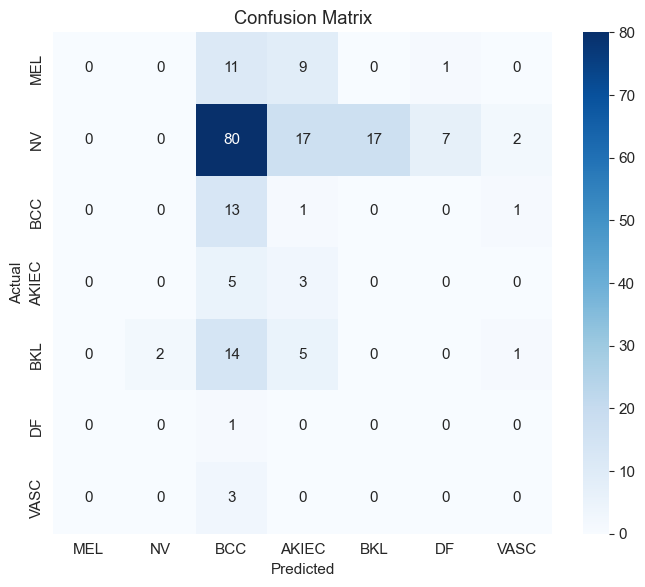

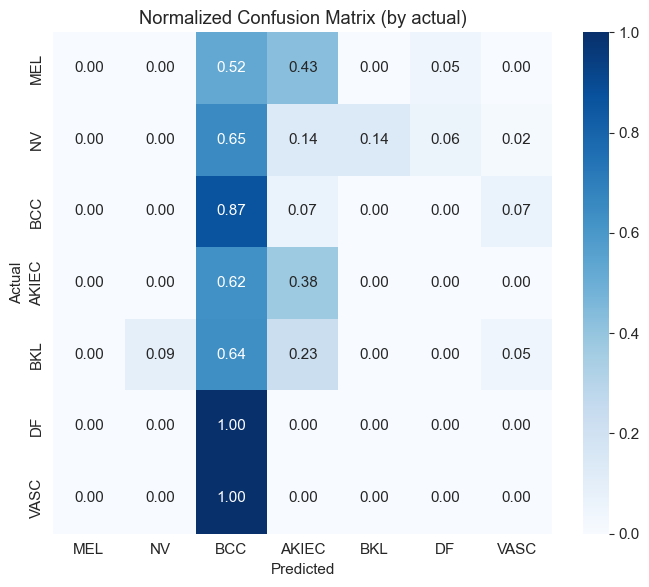


Classification report:

              precision    recall  f1-score   support

         MEL     0.0000    0.0000    0.0000        21
          NV     0.0000    0.0000    0.0000       123
         BCC     0.1024    0.8667    0.1831        15
       AKIEC     0.0857    0.3750    0.1395         8
         BKL     0.0000    0.0000    0.0000        22
          DF     0.0000    0.0000    0.0000         1
        VASC     0.0000    0.0000    0.0000         3

    accuracy                         0.0829       193
   macro avg     0.0269    0.1774    0.0461       193
weighted avg     0.0115    0.0829    0.0200       193



C:\Users\sudha\AppData\Local\Temp\ipykernel_6464\830470355.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vals, y=names, palette="deep", ax=ax)


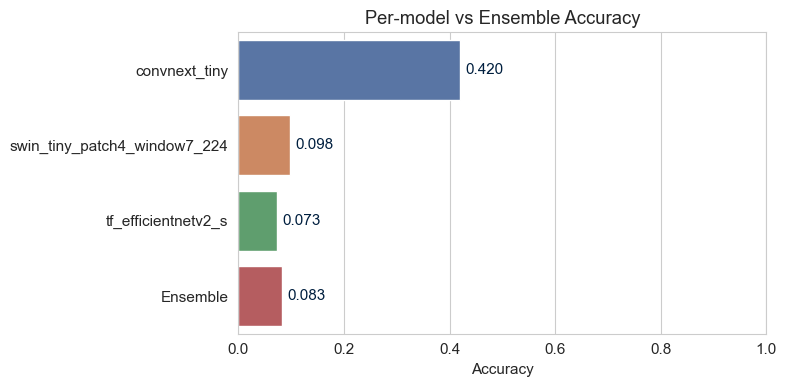

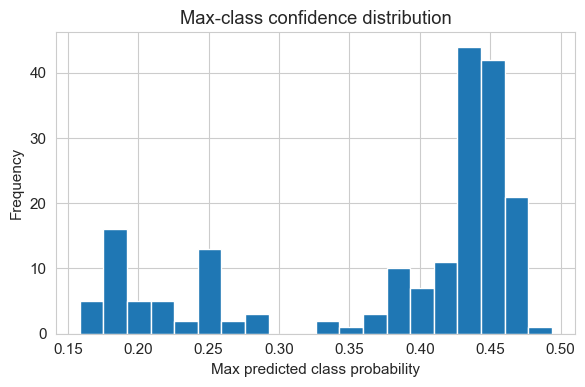

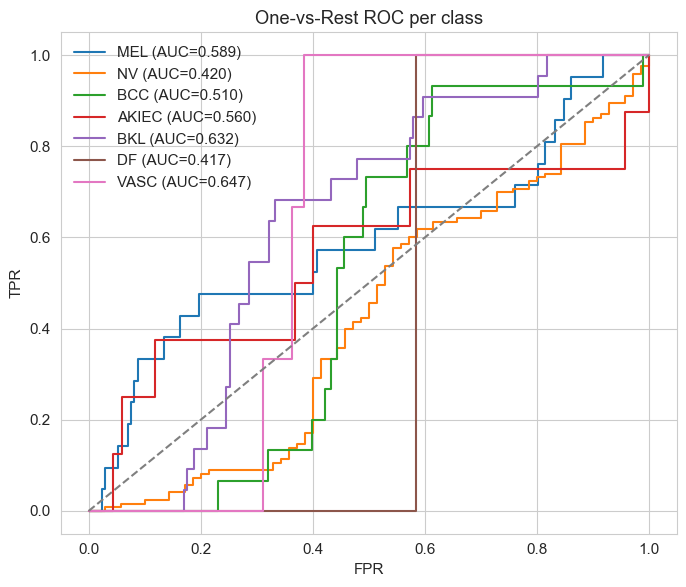

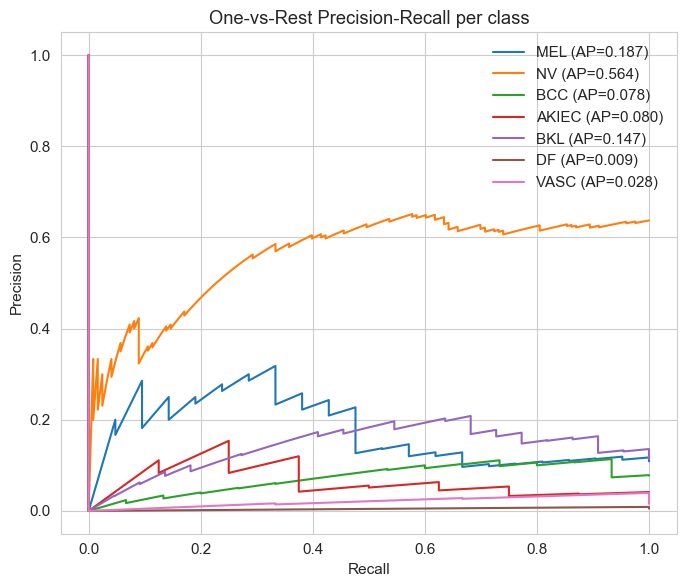

Mean AUC: 0.5394205352666727 Mean AP: 0.1561945786404484

Number of misclassified samples: 177


,index,filename,true,pred
0,0,ISIC_0034321.jpg,NV,BCC
1,1,ISIC_0034322.jpg,NV,BCC
2,3,ISIC_0034324.jpg,NV,BKL
3,4,ISIC_0034325.jpg,NV,BCC
4,5,ISIC_0034326.jpg,BKL,BCC
5,6,ISIC_0034328.jpg,NV,BCC
6,7,ISIC_0034329.jpg,MEL,BCC
7,8,ISIC_0034330.jpg,NV,BCC
8,9,ISIC_0034331.jpg,NV,BCC
9,10,ISIC_0034332.jpg,AKIEC,BCC



Saved figures and misclassified_samples.csv into results_visuals/.


In [ ]:
 
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Ensure required globals exist
assert 'y_true' in globals() and y_true is not None, "y_true not found"
assert ('ensemble_preds' in globals() or 'avg_probs' in globals()), "ensemble predictions or avg_probs missing"

# Use available names
y_true = np.asarray(y_true)
if 'ensemble_preds' in globals() and globals()['ensemble_preds'] is not None:
    final_preds = np.asarray(ensemble_preds)
elif 'final_preds' in globals() and globals()['final_preds'] is not None:
    final_preds = np.asarray(final_preds)
else:
    # derive from avg_probs
    avg_probs = np.asarray(globals().get('avg_probs'))
    if avg_probs.ndim == 2:
        final_preds = np.argmax(avg_probs, axis=1)
    else:
        final_preds = (avg_probs > 0.5).astype(int)

# CLASS_NAMES
CLASS_NAMES = globals().get('CLASS_NAMES', [str(i) for i in range(len(np.unique(y_true)))])

# plotting style (white bg, navy text)
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "#001f3f",
    "xtick.color": "#001f3f",
    "ytick.color": "#001f3f",
    "text.color": "#001f3f",
    "font.size": 11
})
sns.set_style("whitegrid")
out_dir = Path("results_visuals")
out_dir.mkdir(exist_ok=True)

print("Shapes -> y_true:", y_true.shape, "final_preds:", final_preds.shape)

# 1) Confusion matrix (counts)
cm = confusion_matrix(y_true, final_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(out_dir / "confusion_matrix.png", dpi=300, facecolor='white')
plt.show()

# 2) Normalized CM
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)
plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Normalized Confusion Matrix (by actual)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(out_dir / "confusion_matrix_norm.png", dpi=300, facecolor='white')
plt.show()

# 3) Classification report
print("\nClassification report:\n")
print(classification_report(y_true, final_preds, target_names=CLASS_NAMES, digits=4, zero_division=0))

# 4) Per-model accuracy bar (if per-model preds exist)
per_model_acc = {}
all_model_preds = globals().get('all_model_preds', {})
all_model_probs = globals().get('all_model_probs', {})
if isinstance(all_model_preds, dict) and all_model_preds:
    for name, preds in all_model_preds.items():
        per_model_acc[name] = accuracy_score(y_true, np.asarray(preds))
# If per-model probs present, compute from probs
elif isinstance(all_model_probs, dict) and all_model_probs:
    for name, probs in all_model_probs.items():
        p = np.asarray(probs)
        if p.ndim == 2:
            preds = p.argmax(axis=1)
        else:
            preds = (p > 0.5).astype(int)
        per_model_acc[name] = accuracy_score(y_true, preds)

# ensemble accuracy
per_model_acc['Ensemble'] = accuracy_score(y_true, final_preds)

if per_model_acc:
    names = list(per_model_acc.keys())
    vals = [per_model_acc[n] for n in names]
    fig, ax = plt.subplots(figsize=(8,4))
    sns.barplot(x=vals, y=names, palette="deep", ax=ax)
    ax.set_xlim(0,1)
    ax.set_xlabel("Accuracy")
    ax.set_title("Per-model vs Ensemble Accuracy")
    for i,v in enumerate(vals):
        ax.text(v+0.01, i, f"{v:.3f}", va='center', color="#001f3f")
    plt.tight_layout()
    plt.savefig(out_dir / "models_accuracy_bar.png", dpi=300, facecolor='white')
    plt.show()
else:
    print("No per-model predictions/probs available to compute single-model accuracies.")

# 5) Confidence histogram (ensemble probabilities)
if 'avg_probs' in globals() and globals()['avg_probs'] is not None:
    avg_probs = np.asarray(globals()['avg_probs'])
    plt.figure(figsize=(6,4))
    if avg_probs.ndim == 1:
        plt.hist(avg_probs, bins=20)
        plt.xlabel("Predicted probability"); plt.title("Confidence distribution")
    else:
        plt.hist(avg_probs.max(axis=1), bins=20)
        plt.xlabel("Max predicted class probability"); plt.title("Max-class confidence distribution")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(out_dir / "confidence_hist.png", dpi=300, facecolor='white')
    plt.show()
else:
    print("avg_probs not found; skipping confidence histogram.")

# 6) ROC & PR curves (one-vs-rest for multiclass)
if 'avg_probs' in globals() and globals()['avg_probs'] is not None:
    avg_probs = np.asarray(globals()['avg_probs'])
    y_bin = label_binarize(y_true, classes=np.arange(len(CLASS_NAMES)))
    if avg_probs.ndim == 1:
        pos = avg_probs
        fpr, tpr, _ = roc_curve(y_true, pos)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5)); plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'--')
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.tight_layout()
        plt.savefig(out_dir / "roc_curve.png", dpi=300, facecolor='white'); plt.show()

        prec, rec, _ = precision_recall_curve(y_true, pos)
        ap = average_precision_score(y_true, pos)
        plt.figure(figsize=(6,5)); plt.plot(rec, prec, label=f'AP={ap:.3f}'); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall"); plt.legend(); plt.tight_layout()
        plt.savefig(out_dir / "pr_curve.png", dpi=300, facecolor='white'); plt.show()
    else:
        # multiclass: one-vs-rest per class
        plt.figure(figsize=(7,6))
        mean_auc = []
        for i, cname in enumerate(CLASS_NAMES):
            try:
                fpr, tpr, _ = roc_curve(y_bin[:, i], avg_probs[:, i])
                roc_auc = auc(fpr, tpr)
                mean_auc.append(roc_auc)
                plt.plot(fpr, tpr, label=f'{cname} (AUC={roc_auc:.3f})')
            except Exception as e:
                print("ROC failed for class", cname, ":", e)
        plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("One-vs-Rest ROC per class"); plt.legend(); plt.tight_layout()
        plt.savefig(out_dir / "roc_ovr_per_class.png", dpi=300, facecolor='white'); plt.show()

        # PR curves per class
        plt.figure(figsize=(7,6))
        mean_ap = []
        for i, cname in enumerate(CLASS_NAMES):
            try:
                prec, rec, _ = precision_recall_curve(y_bin[:, i], avg_probs[:, i])
                ap = average_precision_score(y_bin[:, i], avg_probs[:, i])
                mean_ap.append(ap)
                plt.plot(rec, prec, label=f'{cname} (AP={ap:.3f})')
            except Exception as e:
                print("PR failed for class", cname, ":", e)
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("One-vs-Rest Precision-Recall per class"); plt.legend(); plt.tight_layout()
        plt.savefig(out_dir / "pr_ovr_per_class.png", dpi=300, facecolor='white'); plt.show()
        print("Mean AUC:", np.mean(mean_auc) if mean_auc else None, "Mean AP:", np.mean(mean_ap) if mean_ap else None)
else:
    print("avg_probs missing; skipping ROC/PR curves.")

# 7) Error analysis table (first 20 misclassified samples)
errors = []
if 'val_loader' in globals() and globals()['val_loader'] is not None:
    ds = globals()['val_loader'].dataset
    try:
        fnames = [str(p.name) for p, _ in ds.samples]
    except Exception:
        fnames = [str(i) for i in range(len(y_true))]
else:
    fnames = [str(i) for i in range(len(y_true))]

for i, (yt, yp) in enumerate(zip(y_true, final_preds)):
    if yt != yp:
        errors.append({'index': i, 'filename': fnames[i] if i < len(fnames) else str(i), 'true': CLASS_NAMES[int(yt)], 'pred': CLASS_NAMES[int(yp)]})
errors_df = pd.DataFrame(errors)
print("\nNumber of misclassified samples:", len(errors_df))
display(errors_df.head(20))

# Save errors table
errors_df.to_csv(out_dir / "misclassified_samples.csv", index=False)
print("\nSaved figures and misclassified_samples.csv into results_visuals/.")
